<h1 style="font-size:2.0em; font-weight:bold; text-align:center;">Feature Engineering & Baseline Model Training</h1>

Inspired by Ferwerda and Joras (2019), **"Tariffs, Sanctions and the Problem of Trade-Based Money Laundering"** - European Studies on Crime and Criminal Justice, this data science project simulates and detects Trade-Based Money Laundering (TBML) within corporate banking transactions. It focuses on identifying behavioral patterns that emerge during periods of tariff and sanctions-related tensions (e.g., China–U.S. trade conflict).

The dataset spans from **April 2, 2025, to December 31, 2025**, under the assumption that a mid-2025 trade war escalation introduces new tariffs and restrictions, triggering abnormal or suspicious transaction activity.

For **Feature Engineering**, we handled numerical and categorical variables separately with the following steps: 

- Handle missing values.

- Create new features.

- Apply feature transformations.

For **Baseline Model Training**: Use Logistic Regression and calculate key evaluation metrics such as accuracy, precision, recall, F1-score, and ROC-AUC to assess model performance.



In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/EDA_nordic_transactions_with_fraud.csv')

In [3]:
df.drop(['Unnamed: 0'], inplace=True, axis=1)
df.head()

,transaction_id,transaction_date,booking_date,value_date,payment_date,amount,currency,from_account_id,from_account_name,counterparty_account_id,...,from_account_expected_turnover,amount_eur,transaction_day,transaction_mon,booking_day,booking_mon,value_day,value_mon,payment_day,payment_mon
0,1d8bdb66-975b-4441-8b85-b96727eaf2ec,2025-11-06,2025-11-08,2025-11-09,2025-11-11,203701.64,NOK,GB74RNID44875257607090,"Rodriguez, Myers and Giles",GB59UNYK99322750860913,...,1021011.83,17689.450418,6,11,8,11,9,11,11,11
1,84b060bf-10a8-470d-8f8a-509a60c97a82,2025-04-19,2025-04-21,2025-04-21,2025-04-22,427642.34,SEK,GB61JXRV87150476031654,"Hensley, Brandt and Mckenzie",GB06AOZA90321060059678,...,1491544.84,39419.490252,19,4,21,4,21,4,22,4
2,f94387bf-0550-44bf-a3ab-fd853f9f886c,2025-04-09,2025-04-11,2025-04-11,2025-04-12,464717.51,NOK,GB12IOQU60716165244897,Newton LLC,GB89BCSP82436524967772,...,1967002.12,40356.068568,9,4,11,4,11,4,12,4
3,8185f0fb-960a-4be3-bd7f-11c3169c9ed7,2025-06-12,2025-06-14,2025-06-14,2025-06-15,265887.72,DKK,GB57OMHZ93858433256887,Frye Ltd,GB98VFPC29413119107640,...,1017836.10,35639.589989,12,6,14,6,14,6,15,6
4,f27edb54-08cc-4604-ba95-9b36a1bc48d7,2025-07-18,2025-07-20,2025-07-20,2025-07-21,376947.00,NOK,GB23JEMB99152786535417,Contreras-Baker,GB36FLGI40138482504680,...,456226.44,32734.077480,18,7,20,7,20,7,21,7


## <h2 style="font-size: 1.8em; font-weight: bold;"> Feature Engineering </h2>

## <h3 style="font-size: 1.6em; font-weight: bold;"> 1. Handling Missing Values </h2>

In [4]:
#First, start with categorical features.
feature_na = [feature for feature in df.columns 
              if df[feature].isnull().sum()>1 and df[feature].dtypes == 'O']
feature_na

['counterparty_name',
 'narrative',
 'related_trade_invoice_id',
 'end_to_end_identification',
 'from_account_business_type']

In EDA, we found that only `related_trade_invoice_id` is related to `is_fraud`, so we will handle this column separately.

In [5]:
#Drop or fill with 0 for columns that show no meaningful correlation with the target variable.
for feature in feature_na: 
    if feature != 'related_trade_invoice_id':
      df[feature_na] = df[feature_na].fillna(0)
    else: # Replace missing value with a new label 
     df[feature_na] = df[feature_na].fillna ('missing')
df.isnull().sum()

transaction_id                    0
transaction_date                  0
booking_date                      0
value_date                        0
payment_date                      0
amount                            0
currency                          0
from_account_id                   0
from_account_name                 0
counterparty_account_id           0
counterparty_name                 0
counterparty_country              0
counterparty_bank_bic             0
counterparty_business_type        0
narrative                         0
payment_purpose_code              0
related_trade_invoice_id          0
swift_message_type                0
transaction_status                0
transaction_type_description      0
end_to_end_identification         0
is_fraud                          0
from_account_country              0
from_account_business_type        0
from_account_expected_turnover    0
amount_eur                        0
transaction_day                   0
transaction_mon             

In this project, there are no missing numeric values. But if there were, we’d use the median or mode to fill them in, since we found outliers during EDA.

## <h2 style="font-size: 1.6em; font-weight: bold;"> 2. New Features Creation </h2>

**Numeric Features**

`turnover_jump_pct`

Calculate the Turnover Jump % to spot any unusual spikes in transaction volumes that could indicate suspicious activity.

In [6]:
df.rename(columns={'from_account_expected_turnover': 'expected_turnover'}, inplace=True) 
df['turnover_jump_pct'] = (100.00* df['amount_eur']/ df['expected_turnover']).round(2)
len(df.loc[df['turnover_jump_pct'] > 100.00])

407

We found 407 transactions with a turnover jump percentage over 100%.

`risky_flag`

Flag all transactions sent to risky countries (as defined by sanctions and potential tariff threats)

In [7]:
risky_countries = ['HK', 'SG', 'CN', 'RU']

df['is_rirsk _country'] = df['counterparty_country'].isin(risky_countries).astype(int)

count_countries_flag = (df['is_rirsk _country'] == 1).sum()
count_countries_flag

3010

We found 3,010 transactions sent to risky countries.

`split_payment`

To flag `split_payment`, we applied business rules to identify accounts that show any of these signs:

- Made multiple payments within a single day.

- Had repeated or similar transaction amounts

- Made more than a set number of payments (high frequency).

In [8]:
# Case 1: Made multiple payments within a single day
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
time_diff = df.groupby('from_account_name')['transaction_date'].diff()
df['is_sequential']= (time_diff <= pd.Timedelta(days=1)).astype(int)

# Case 2: Had repeated or similar transaction amounts
df['is_repeated_amount'] = df.groupby('from_account_name')['amount_eur'].transform(
    lambda x: x.duplicated(keep=False)
).astype(int)

# Case 3: Made more than 3 payments (high frequency)
txn_count = df.groupby('from_account_name')['transaction_id'].transform('count')
df['is_high_frequency'] = (txn_count >= 3).astype(int)

# Final flag: if any condition is met
df['is_split'] = (df['is_sequential'] | df['is_repeated_amount'] | df['is_high_frequency']
)

count_split_payment = (df['is_split'] ==1).sum()
count_split_payment

1395

We have 1,395 transactions marked as split payments.

## <h2 style="font-size: 1.6em; font-weight: bold;"> 3. Feature Transformation </h2>

**3.1 Continuous Variable**

In [9]:
num_variables = df.select_dtypes(include='float')
num_variables.columns

Index(['amount', 'expected_turnover', 'amount_eur', 'turnover_jump_pct'], dtype='object')

As discovered during EDA, most numerical variables are skewed and require transformation.

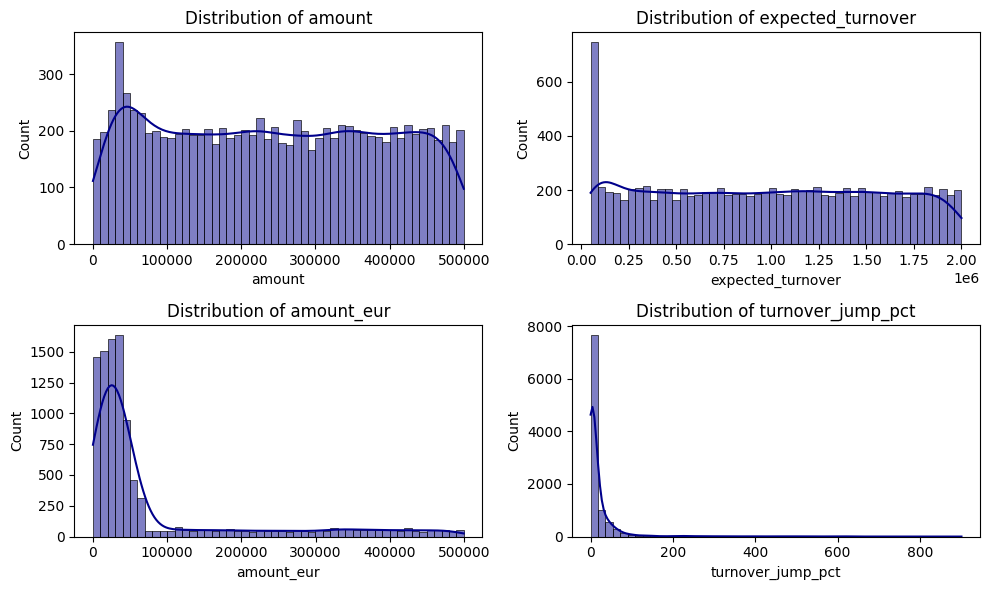

In [10]:
plt.figure(figsize=(10, 6))
for i, col in enumerate(num_variables,1):
      df_copy = df.copy()
      plt.subplot(2, 2, i)
      sns.histplot(df_copy[col], bins=50, kde=True, color='darkblue')
      plt.title(f'Distribution of {col}')
      plt.xlabel(col)
      plt.ylabel('Count')

plt.tight_layout()
plt.show()

Let's apply log transformation.

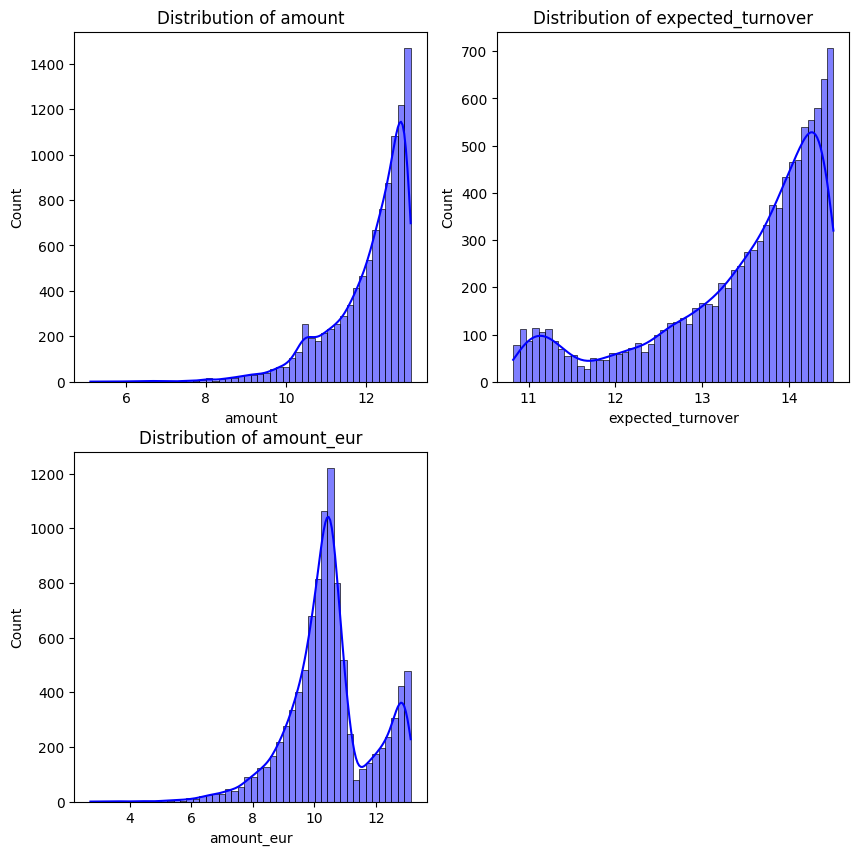

In [11]:

from numpy import log

plt.figure(figsize=(10, 10))
for i, col in enumerate(num_variables,1):
    df_copy=df.copy()
    if 0 in df_copy[col].unique():
        pass
    else:
       df_copy[col] = np.log(df_copy[col])
       plt.subplot(2, 2, i)
       sns.histplot(df_copy[col], bins=50, kde=True, color='blue')
       plt.title(f'Distribution of {col}')
       plt.xlabel(col)
       plt.ylabel('Count')

 

The results have improved slightly, but not significantly. Let's try applying the Box-Cox transformation again.

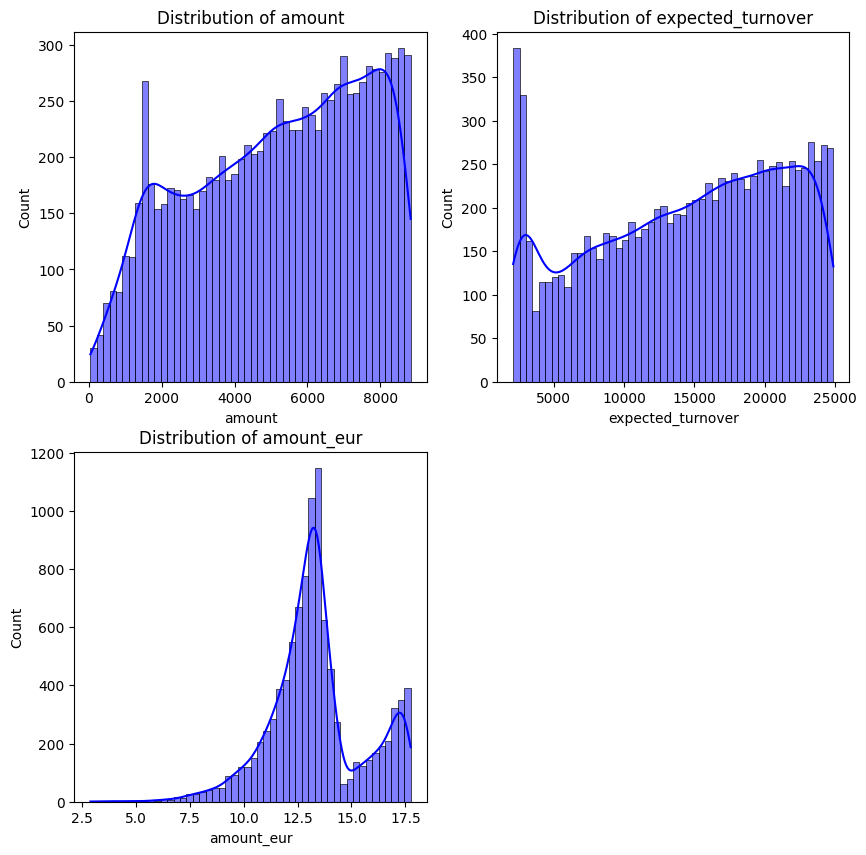

In [12]:
from scipy.stats import boxcox

plt.figure(figsize=(10, 10))
for i, col in enumerate(num_variables,1):
    if 0 in df[col].unique():
        pass
    else:
       bc_result,_ = boxcox(df[col])
       plt.subplot(2, 2, i)
       sns.histplot(bc_result, bins=50, kde=True, color='blue')
       plt.title(f'Distribution of {col}')
       plt.xlabel(col)
       plt.ylabel('Count')

It seems Box-Cox performs better than log transformation.

**3.2 Categorical Feature**

In [13]:
df['transaction_date'] = df['transaction_date'].astype(str)
categorical_features = df.dtypes[df.dtypes == 'object'].index.to_list()

#Identify the number of unique categories in each categorical (object) column.
for feature in categorical_features: 
    count_value = df[feature].value_counts()
    print (feature,'-', len(count_value),'categories')


transaction_id - 10116 categories
transaction_date - 273 categories
booking_date - 275 categories
value_date - 276 categories
payment_date - 279 categories
currency - 5 categories
from_account_id - 10116 categories
from_account_name - 8776 categories
counterparty_account_id - 10116 categories
counterparty_name - 8378 categories
counterparty_country - 10 categories
counterparty_bank_bic - 4 categories
counterparty_business_type - 5 categories
narrative - 8826 categories
payment_purpose_code - 5 categories
related_trade_invoice_id - 2880 categories
swift_message_type - 3 categories
transaction_status - 3 categories
transaction_type_description - 4 categories
end_to_end_identification - 5324 categories
from_account_country - 4 categories
from_account_business_type - 6 categories


In [14]:
drop_col = []
date_col = ['transaction_date', 'booking_date', 'value_date', 'payment_date']
for feature in categorical_features: 
    count_value = df[feature].value_counts()
    if len(count_value) == len(df):
      drop_col.append(feature)
    if feature in date_col:
      drop_col.append(feature)
print(drop_col)

['transaction_id', 'transaction_date', 'booking_date', 'value_date', 'payment_date', 'from_account_id', 'counterparty_account_id']


*Rare Categorical Feature*

We will lable 'rare_var' for categorical variables that appear in less than 1% of the observations, as they carry little significance for the analysis.

In [15]:
df = df.drop(columns=drop_col)

In [16]:
categorical_features = df.dtypes[df.dtypes == 'object'].index.to_list()
df[categorical_features].nunique()

currency                           5
from_account_name               8776
counterparty_name               8378
counterparty_country              10
counterparty_bank_bic              4
counterparty_business_type         5
narrative                       8826
payment_purpose_code               5
related_trade_invoice_id        2880
swift_message_type                 3
transaction_status                 3
transaction_type_description       4
end_to_end_identification       5324
from_account_country               4
from_account_business_type         6
dtype: int64

In [17]:
for feature in categorical_features:
     counts = df[feature].value_counts()
     rare_categories = counts[counts < len(df) * 0.01].index
     df[feature] = df[feature].apply(lambda x: 'rare_var' if x in rare_categories else x)

In [18]:
df[categorical_features].nunique()

currency                         5
from_account_name                1
counterparty_name                2
counterparty_country            10
counterparty_bank_bic            4
counterparty_business_type       5
narrative                        4
payment_purpose_code             5
related_trade_invoice_id         2
swift_message_type               3
transaction_status               3
transaction_type_description     4
end_to_end_identification        2
from_account_country             4
from_account_business_type       6
dtype: int64

*Categorical Feature*

For high-cardinality features, we use mean encoding to convert categorical variables into numerical values based on their relationship with the target variable `is_fraud`.

In [19]:
#high_card_feature = []
#for feature in categorical_features: 
    #if feature not in drop_col:
     #count_value = categorical_features[feature].value_counts()
     #if len(count_value) > 10:
       #high_card_feature.append(feature)


In [20]:
##for feature in high_card_feature:
      #labels_ordered = df.groupby([feature])['is_fraud'].mean().sort_values().index
      #labels_ordered = {k: i for i, k in enumerate(labels_ordered, 0)}
      #df[feature] = df[feature].map(labels_ordered)
#df[high_card_feature].nunique()

In [21]:
#from sklearn.model_selection import KFold

#from sklearn.model_selection import KFold

#kf = KFold(n_splits=5, shuffle=True, random_state=42)

#for feature in high_card_feature:
    #if feature not in drop_col:
        #df[feature] = np.nan  # clear column to store encoded values

        #for train_idx, val_idx in kf.split(df):
            #means = df.iloc[train_idx].groupby(feature)['is_fraud'].mean()
            #df.loc[df.index[val_idx], feature] = df.loc[df.index[val_idx], feature].map(means)

        #df[feature].fillna(df['is_fraud'].mean(), inplace=True)

#df[high_card_feature].nunique()


In [22]:
#Collect high-cardinality features that have no relationship with is_fraud into a drop list
#for feature in high_card_feature:
  #if df[feature].nunique() == 1 and df[feature].unique()[0] == 0:
        #drop_col.append(feature)
#print(drop_col)

For low-cardinality features, we apply one-hot encoding.

In [23]:
df_encoded = pd.get_dummies(df[categorical_features], drop_first=True)
df_encoded.columns = [f"{col}_enc" for col in df_encoded.columns] 
df_encoded.shape

(10116, 45)

In [25]:
data = pd.concat([
    df.drop(columns=categorical_features).reset_index(drop=True),
    df_encoded.reset_index(drop=True)
], axis=1)
data.shape

(10116, 63)

Save a clean dataset with the target variable is_fraud as the first column.

In [26]:
cols = ['is_fraud'] + [col for col in data.columns if col != 'is_fraud']
data = data[cols]
data.to_csv('data/CLEAN_nordic_transactions_with_fraud.csv')

**The correlations between the dependent variables.**

Create a histogram of the correlation values and identify those that are most correlated (either positively or negatively).

In [27]:
feature_cols = data.columns.drop('is_fraud')
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.nan
    
# Stack the data and convert to a data frame
corr_values = (corr_values
               .stack()
               .to_frame()
               .reset_index()
               .rename(columns={'level_0':'feature1',
                                'level_1':'feature2',
                                0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

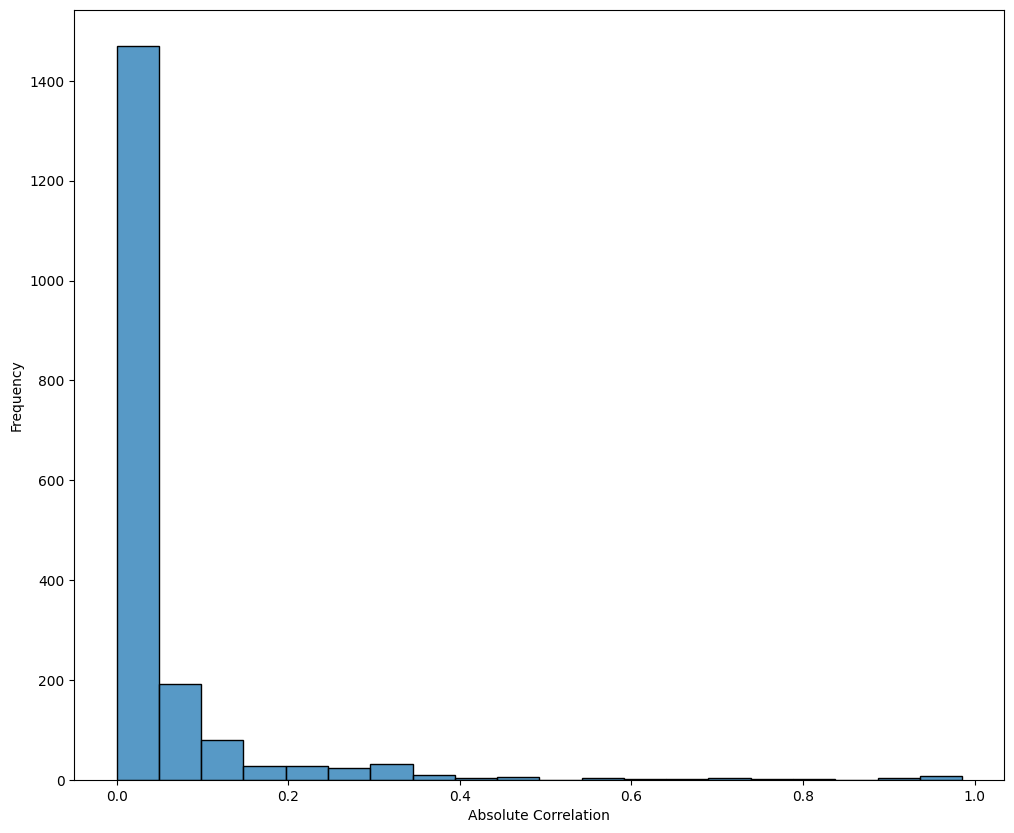

In [28]:
plt.figure(figsize=(12,10))
sns.histplot(corr_values['abs_correlation'], bins=20)
plt.xlabel('Absolute Correlation')
plt.ylabel('Frequency')
plt.show()

In [29]:
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
352,booking_mon,value_mon,0.985349,0.985349
239,transaction_mon,booking_mon,0.983254,0.983254
241,transaction_mon,value_mon,0.968637,0.968637
461,value_mon,payment_mon,0.957749,0.957749
981,currency_NOK_enc,from_account_country_NO_enc,0.950904,0.950904
937,currency_EUR_enc,from_account_country_FI_enc,0.947619,0.947619
1024,currency_SEK_enc,from_account_country_SE_enc,0.946090,0.946090
354,booking_mon,payment_mon,0.943111,0.943111
243,transaction_mon,payment_mon,0.926452,0.926452
1048,currency_USD_enc,narrative_Payment for services_enc,0.914016,0.914016


when we see something that's so highly correlated, we may want to do feature selection.

## <h2 style="font-size: 1.8em; font-weight: bold;"> Baseline Model Training </h2>

In [30]:
data.dtypes.value_counts()

bool       45
int64       9
int32       5
float64     4
Name: count, dtype: int64

In [31]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report

As `is_fraud` is imbalanced, so we use StratifiedShuffleSplit() to maintain the same ratio of predictor classes.

In [32]:
X = data[feature_cols]
y = data['is_fraud']

strat_shuf_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_idx, test_idx in strat_shuf_split.split(X, y):
  X_train = data.loc[train_idx, feature_cols]
  y_train = data.loc[train_idx, 'is_fraud']

  X_test  = data.loc[test_idx, feature_cols]
  y_test  = data.loc[test_idx, 'is_fraud']

In [33]:
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

In [34]:
y_pred = lr.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9792421746293245

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      2945
           1       0.80      0.40      0.53        90

    accuracy                           0.98      3035
   macro avg       0.89      0.70      0.76      3035
weighted avg       0.98      0.98      0.98      3035



In [35]:
feature_names = X_train.columns                                   

coefficients = lr.coef_[0]                  

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(coef_df.head(10)) 

                                       Feature   Coefficient
1                            expected_turnover -3.041754e-05
2                                   amount_eur  4.218878e-06
0                                       amount  4.152462e-06
11                           turnover_jump_pct  3.701904e-08
9                                  payment_day  2.536223e-09
3                              transaction_day  2.504748e-09
7                                    value_day  2.429981e-09
5                                  booking_day  1.584368e-09
38  narrative_Invoice for electronic parts_enc  1.420675e-09
40                      narrative_rare_var_enc -1.183893e-09


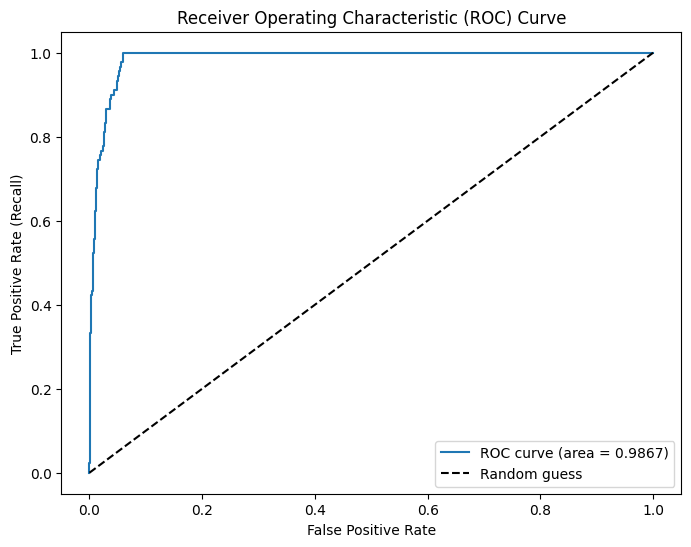

In [36]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

y_proba = lr.predict_proba(X_test)[:, 1] 
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()